In [10]:

import torch
from torch.autograd import grad
from torch_geometric.utils import subgraph
from torch_geometric.transforms import TwoHop
import numpy as np
import argparse
from datetime import datetime
import logging
from inspect import currentframe, getframeinfo
import os
import sys
from time import time
import json

if '..' not in sys.path:
    sys.path.insert(0, '..')
# Add the parent directory to sys.path

from utils.printing_utils import printd, filename_n_line_str

from tests import tests
from utils import utils
from utils.plotting import *
import anomaly_detection as ad
from trainer import Trainer
from scripting_utils import print_prior_training_stats
from datasets.import_dataset import import_dataset

In [ ]:
# see if the new noise amp is any improvement.
# change the config to also have an optimization config for fit prior fixed feats
#todo: the mission now is to improve detection for small amount of nodes. i think that it means making the prior finer and maybe will need more layers and features
# maybe we can think of features and layers as a type of frequency. 

#feeling lost. the noise amp doesn't work immediately. but the old one did work fine. maybe should first make the fit fixed prior stuff and test that the regular thing the last thing that worked still works just to be safe

# Unsupervised

In [2]:
# COMMUNITIES AND N_ITER
'''experiments from 14.7 with bigclam'''

def get_k_mean_std(meas_array, verbose=False, ax=None, label=None):
    ks = np.unique(meas_array[0])
    ks_means_stds = np.zeros((3, len(ks)))
    ks_means_stds[0] = ks
    for i, k in enumerate(ks):
        indices = np.where(meas_array[0] == k)
        mean = np.mean(meas_array[1][indices])
        std = np.std(meas_array[1][indices])
        ks_means_stds[1, i] = mean
        ks_means_stds[2, i] = std
    if verbose:
        '''notice we are using two sigma and not one'''
        if ax is None:
            fig, ax = plt.subplots()
        ax.errorbar(ks_means_stds[0], ks_means_stds[1], yerr=2*ks_means_stds[2], label=label, linestyle='None', marker='o', capsize=7)
        return ax


# GGAD datasets

### Reddit

Text(0.5, 1.0, 'ieclam')

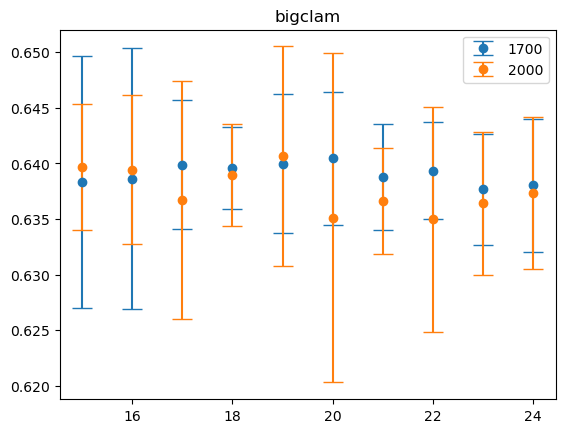

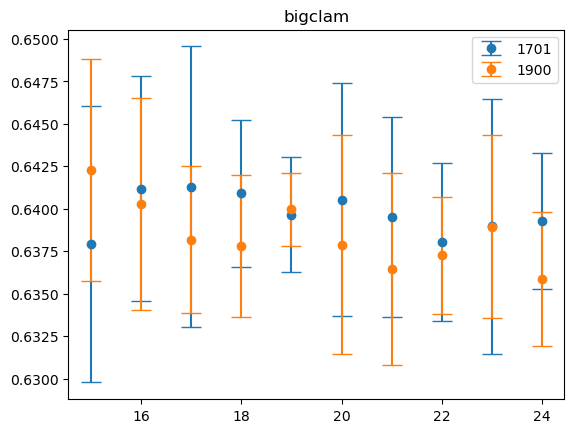

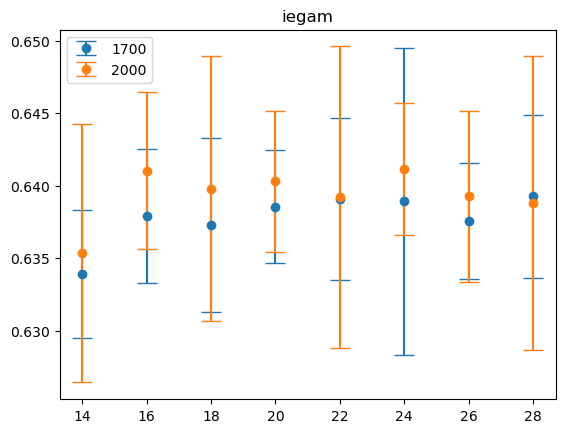

In [7]:

#* if you take enough clusters, the averages will have a gaussian distribution
# todo: i should probably pick these in some crossval process. like optimize everything and pick a test set or optimize and test on some subgraph

path_bigclam_1700 = 'results/unsupervised/community_crossval/bigclam/1700/k_vs_auc_0.npy'
path_bigclam_2000 = 'results/unsupervised/community_crossval/bigclam/2000/k_vs_auc_0.npy'
path_bigclam_2500 = 'results/unsupervised/community_crossval/bigclam/2500/k_vs_auc_0.npy'

path_bigclam_1701 = 'results/unsupervised/community_crossval/bigclam/1701/k_vs_auc_0.npy'
path_bigclam_1900 = 'results/unsupervised/community_crossval/bigclam/1900/k_vs_auc_0.npy'
path_bigclam_1300 = 'results/unsupervised/community_crossval/bigclam/1300/k_vs_auc_0.npy'


path_ieclam_1700 = 'results/unsupervised/community_crossval/ieclam/1700/k_vs_auc_0.npy'
path_ieclam_2000 = 'results/unsupervised/community_crossval/ieclam/2000/k_vs_auc_0.npy'
path_ieclam_2500 = 'results/unsupervised/community_crossval/ieclam/2500/k_vs_auc_0.npy'



bigclam_1700 = np.load(path_bigclam_1700)[:,1:]
bigclam_2000 = np.load(path_bigclam_2000)[:,1:]
bigclam_2500 = np.load(path_bigclam_2500)[:,1:]

bigclam_1701 = np.load(path_bigclam_1701)[:,1:]
bigclam_1900 = np.load(path_bigclam_1900)[:,1:]
bigclam_1300 = np.load(path_bigclam_1300)[:,1:]

ieclam_1700 = np.load(path_ieclam_1700)[:,1:]
ieclam_2000 = np.load(path_ieclam_2000)[:,1:]
ieclam_2500 = np.load(path_ieclam_2500)[:,1:]


# plt.figure()
# plt.scatter(bigclam_1700[0], bigclam_1700[1], label='1700')
# plt.scatter(bigclam_2000[0], bigclam_2000[1], label='2000')
# plt.scatter(bigclam_2500[0], bigclam_2500[1], label='2500')
# plt.title('bigclam')
# plt.legend()

# plt.figure()
# plt.scatter(bigclam_1701[0], bigclam_1701[1], label='1701')
# plt.scatter(bigclam_1900[0], bigclam_1900[1], label='1900')
# plt.scatter(bigclam_1300[0], bigclam_1300[1], label='1300')
# plt.title('bigclam')
# plt.legend()

# plt.figure()
# plt.scatter(ieclam_1700[0], ieclam_1700[1], label='1700')
# plt.scatter(ieclam_2000[0], ieclam_2000[1], label='2000')
# plt.scatter(ieclam_2500[0], ieclam_2500[1], label='2500')
# plt.title('bigclam')
# plt.legend()

#todo: statistical analysis. think that the best will be to take mean - 2*sigma.
#plot error bars
ax = get_k_mean_std(bigclam_1700, verbose=True, label='1700')
get_k_mean_std(bigclam_2000, verbose=True, ax=ax, label='2000')
# get_k_mean_std(bigclam_2500, verbose=True, ax=ax, label='2500')
plt.legend()
plt.title('bigclam')

ax = get_k_mean_std(bigclam_1701, verbose=True, label='1701')
get_k_mean_std(bigclam_1900, verbose=True, ax=ax, label='1900')
# get_k_mean_std(bigclam_1300, verbose=True, ax=ax, label='1300')
plt.legend()
plt.title('bigclam')

ax = get_k_mean_std(ieclam_1700, verbose=True, label='1700')
get_k_mean_std(ieclam_2000, verbose=True, ax=ax, label='2000')
# get_k_mean_std(ieclam_2500, verbose=True, ax=ax, label='2500')
plt.legend()
plt.title('ieclam')




### elliptic

Text(0.5, 1.0, 'bigclam')

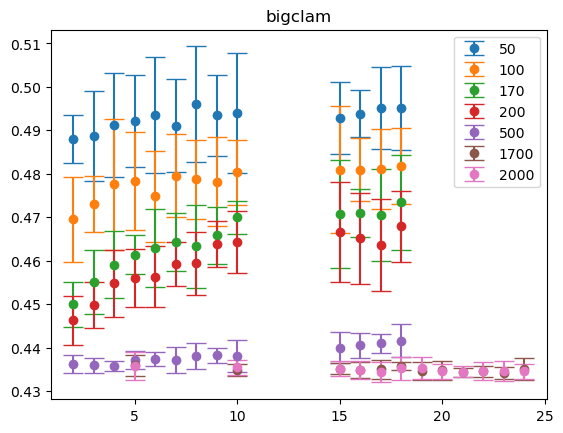

In [42]:
#bigclam

path_bigclam_elliptic_50 = 'unsupervised/find_communities/results/ellipticGGAD/bigclam/50/k_vs_auc_0.npy'
path_bigclam_elliptic_100 = 'unsupervised/find_communities/results/ellipticGGAD/bigclam/100/k_vs_auc_0.npy'
path_bigclam_elliptic_170 = 'unsupervised/find_communities/results/ellipticGGAD/bigclam/170/k_vs_auc_2.npy'
path_bigclam_elliptic_200 = 'unsupervised/find_communities/results/ellipticGGAD/bigclam/200/k_vs_auc_0.npy'
path_bigclam_elliptic_500 = 'unsupervised/find_communities/results/ellipticGGAD/bigclam/500/k_vs_auc_0.npy'

path_bigclam_elliptic_1700 = 'unsupervised/find_communities/results/ellipticGGAD/bigclam/1700/k_vs_auc_0.npy'
path_bigclam_elliptic_2000 = 'unsupervised/find_communities/results/ellipticGGAD/bigclam/2000/k_vs_auc_0.npy'

bigclam_elliptic_50 = np.load(path_bigclam_elliptic_50)[:,:]
bigclam_elliptic_100 = np.load(path_bigclam_elliptic_100)[:,:]
bigclam_elliptic_170 = np.load(path_bigclam_elliptic_170)[:,:]
bigclam_elliptic_200 = np.load(path_bigclam_elliptic_200)[:,:]
bigclam_elliptic_500 = np.load(path_bigclam_elliptic_500)[:,:]

bigclam_elliptic_1700 = np.load(path_bigclam_elliptic_1700)[:,:]
bigclam_elliptic_2000 = np.load(path_bigclam_elliptic_2000)[:,:]

#todo: statistical analysis. think that the best will be to take mean - 2*sigma.
#plot error bars
ax = get_k_mean_std(bigclam_elliptic_50, verbose=True, label='50')
get_k_mean_std(bigclam_elliptic_100, verbose=True, ax=ax, label='100')
get_k_mean_std(bigclam_elliptic_170, verbose=True, ax=ax, label='170')
get_k_mean_std(bigclam_elliptic_200, verbose=True, ax=ax, label='200')
get_k_mean_std(bigclam_elliptic_500, verbose=True, ax=ax, label='500')
get_k_mean_std(bigclam_elliptic_1700, verbose=True, ax=ax, label='1700')
get_k_mean_std(bigclam_elliptic_2000, verbose=True, ax=ax, label='2000')
# get_k_mean_std(bigclam_2500, verbose=True, ax=ax, label='2500')
plt.legend()
plt.title('bigclam')



Text(0.5, 1.0, 'ieclam')

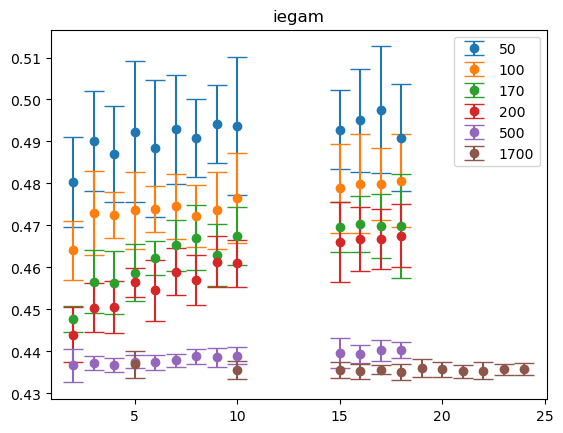

In [43]:
#ieclam

path_ieclam_50 = 'unsupervised/find_communities/results/ellipticGGAD/ieclam/50/k_vs_auc_0.npy'
path_ieclam_100 = 'unsupervised/find_communities/results/ellipticGGAD/ieclam/100/k_vs_auc_0.npy'
path_ieclam_170 = 'unsupervised/find_communities/results/ellipticGGAD/ieclam/170/k_vs_auc_0.npy'
path_ieclam_200 = 'unsupervised/find_communities/results/ellipticGGAD/ieclam/200/k_vs_auc_0.npy'
path_ieclam_500 = 'unsupervised/find_communities/results/ellipticGGAD/ieclam/500/k_vs_auc_0.npy'
path_ieclam_1700 = 'unsupervised/find_communities/results/ellipticGGAD/ieclam/1700/k_vs_auc_0.npy'

ieclam_50 = np.load(path_ieclam_50)[:,:]
ieclam_100 = np.load(path_ieclam_100)[:,:]
ieclam_170 = np.load(path_ieclam_170)[:,:]
ieclam_200 = np.load(path_ieclam_200)[:,:]
ieclam_500 = np.load(path_ieclam_500)[:,:]
ieclam_1700 = np.load(path_ieclam_1700)[:,:]

#todo: statistical analysis. think that the best will be to take mean - 2*sigma.
#plot error bars
ax = get_k_mean_std(ieclam_50, verbose=True, label='50')
get_k_mean_std(ieclam_100, verbose=True, ax=ax, label='100')
get_k_mean_std(ieclam_170, verbose=True, ax=ax, label='170')
get_k_mean_std(ieclam_200, verbose=True, ax=ax, label='200')
get_k_mean_std(ieclam_500, verbose=True, ax=ax, label='500')
get_k_mean_std(ieclam_1700, verbose=True, ax=ax, label='1700')
plt.legend()
plt.title('ieclam')



### photoGGAD

Text(0.5, 1.0, 'bigclam')

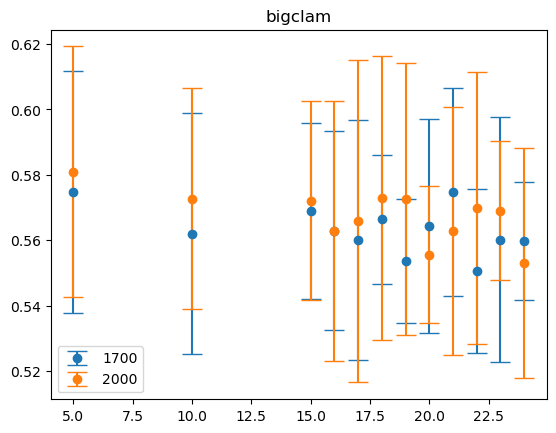

In [23]:

path_bigclam_photo_1700 = 'unsupervised/find_communities/results/photoGGAD/bigclam/1700/k_vs_auc_0.npy'


path_bigclam_photo_2000 = 'unsupervised/find_communities/results/photoGGAD/bigclam/2000/k_vs_auc_0.npy'


bigclam_photo_1700 = np.load(path_bigclam_photo_1700)
bigclam_photo_2000 = np.load(path_bigclam_photo_2000)

#todo: statistical analysis. think that the best will be to take mean - 2*sigma.
#plot error bars

ax = get_k_mean_std(bigclam_photo_1700, verbose=True, label='1700')
get_k_mean_std(bigclam_photo_2000, verbose=True, ax=ax, label='2000')

plt.legend()
plt.title('bigclam')


### tfFinanceGGAD

Text(0.5, 1.0, 'ieclam')

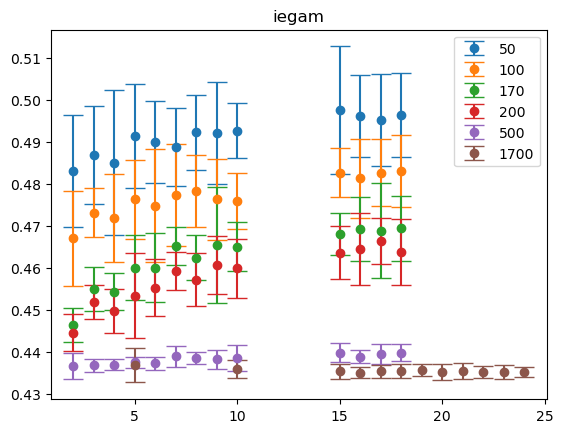

In [44]:
path_ieclam_50 = 'unsupervised/find_communities/results/tfFinanceGGAD/ieclam/50/k_vs_auc_0.npy'
path_ieclam_100 = 'unsupervised/find_communities/results/tfFinanceGGAD/ieclam/100/k_vs_auc_0.npy'
path_ieclam_170 = 'unsupervised/find_communities/results/tfFinanceGGAD/ieclam/170/k_vs_auc_0.npy'
path_ieclam_200 = 'unsupervised/find_communities/results/tfFinanceGGAD/ieclam/200/k_vs_auc_0.npy'
path_ieclam_500 = 'unsupervised/find_communities/results/tfFinanceGGAD/ieclam/500/k_vs_auc_0.npy'
path_ieclam_1700 = 'unsupervised/find_communities/results/tfFinanceGGAD/ieclam/1700/k_vs_auc_0.npy'

ieclam_50 = np.load(path_ieclam_50)[:,:]
ieclam_100 = np.load(path_ieclam_100)[:,:]
ieclam_170 = np.load(path_ieclam_170)[:,:]
ieclam_200 = np.load(path_ieclam_200)[:,:]
ieclam_500 = np.load(path_ieclam_500)[:,:]
ieclam_1700 = np.load(path_ieclam_1700)[:,:]

#todo: statistical analysis. think that the best will be to take mean - 2*sigma.
#plot error bars
ax = get_k_mean_std(ieclam_50, verbose=True, label='50')
get_k_mean_std(ieclam_100, verbose=True, ax=ax, label='100')
get_k_mean_std(ieclam_170, verbose=True, ax=ax, label='170')
get_k_mean_std(ieclam_200, verbose=True, ax=ax, label='200')
get_k_mean_std(ieclam_500, verbose=True, ax=ax, label='500')
get_k_mean_std(ieclam_1700, verbose=True, ax=ax, label='1700')
plt.legend()
plt.title('ieclam')


Text(0.5, 1.0, 'bigclam')

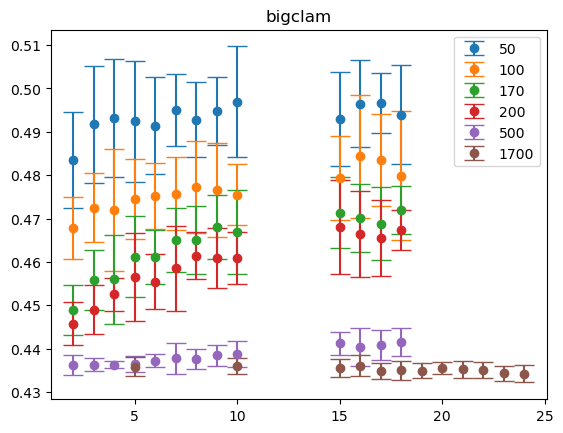

In [45]:
path_bigclam_50 = 'unsupervised/find_communities/results/tfFinanceGGAD/bigclam/50/k_vs_auc_0.npy'
path_bigclam_100 = 'unsupervised/find_communities/results/tfFinanceGGAD/bigclam/100/k_vs_auc_0.npy'
path_bigclam_170 = 'unsupervised/find_communities/results/tfFinanceGGAD/bigclam/170/k_vs_auc_0.npy'
path_bigclam_200 = 'unsupervised/find_communities/results/tfFinanceGGAD/bigclam/200/k_vs_auc_0.npy'
path_bigclam_500 = 'unsupervised/find_communities/results/tfFinanceGGAD/bigclam/500/k_vs_auc_0.npy'
path_bigclam_1700 = 'unsupervised/find_communities/results/tfFinanceGGAD/bigclam/1700/k_vs_auc_0.npy'

bigclam_50 = np.load(path_bigclam_50)[:,:]
bigclam_100 = np.load(path_bigclam_100)[:,:]
bigclam_170 = np.load(path_bigclam_170)[:,:]
bigclam_200 = np.load(path_bigclam_200)[:,:]
bigclam_500 = np.load(path_bigclam_500)[:,:]
bigclam_1700 = np.load(path_bigclam_1700)[:,:]

#todo: statistical analysis. think that the best will be to take mean - 2*sigma.
#plot error bars
ax = get_k_mean_std(bigclam_50, verbose=True, label='50')
get_k_mean_std(bigclam_100, verbose=True, ax=ax, label='100')
get_k_mean_std(bigclam_170, verbose=True, ax=ax, label='170')
get_k_mean_std(bigclam_200, verbose=True, ax=ax, label='200')
get_k_mean_std(bigclam_500, verbose=True, ax=ax, label='500')
get_k_mean_std(bigclam_1700, verbose=True, ax=ax, label='1700')
plt.legend()
plt.title('bigclam')

### redditGGAD

Text(0.5, 1.0, 'reddit ieclam')

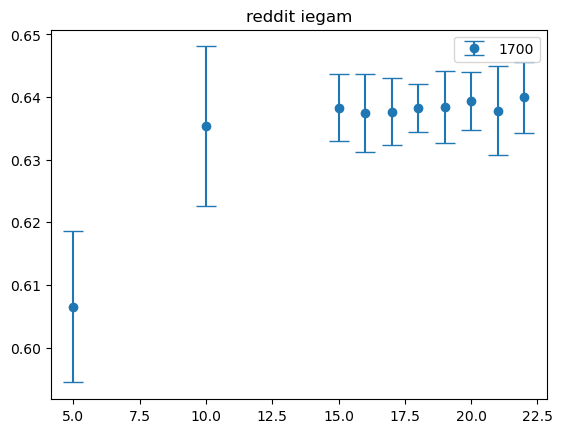

In [34]:
path_ieclam_reddit_1700 = 'unsupervised/find_communities/results/redditGGAD/ieclam/1700/k_vs_auc_0.npy'


bigclam_reddit_1700 = np.load(path_ieclam_reddit_1700)[:,:-20]

#todo: statistical analysis. think that the best will be to take mean - 2*sigma.
#plot error bars

ax = get_k_mean_std(bigclam_reddit_1700, verbose=True, label='1700')

plt.legend()
plt.title('reddit ieclam')


# Synthetic from Dominant

### Flickr

Text(0.5, 1.0, 'bigclam')

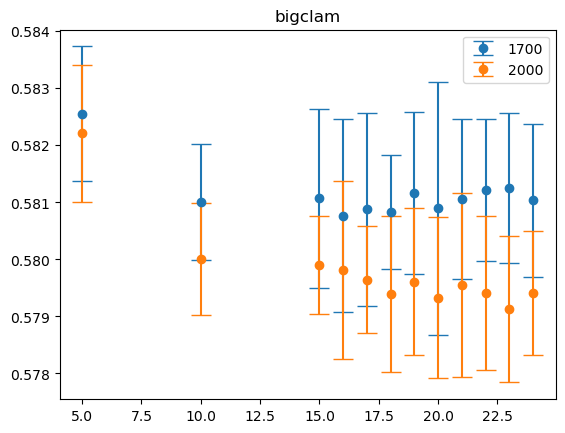

In [35]:

path_bigclam_flickr_1700 = 'unsupervised/find_communities/results/Flickr/bigclam/1700/k_vs_auc_0.npy'


path_bigclam_flickr_2000 = 'unsupervised/find_communities/results/Flickr/bigclam/2000/k_vs_auc_0.npy'


bigclam_flickr_1700 = np.load(path_bigclam_flickr_1700)
bigclam_flickr_2000 = np.load(path_bigclam_flickr_2000)

#todo: statistical analysis. think that the best will be to take mean - 2*sigma.
#plot error bars

ax = get_k_mean_std(bigclam_flickr_1700, verbose=True, label='1700')
get_k_mean_std(bigclam_flickr_2000, verbose=True, ax=ax, label='2000')

plt.legend()
plt.title('bigclam')


### BlogCatalog

Text(0.5, 1.0, 'bigclam')

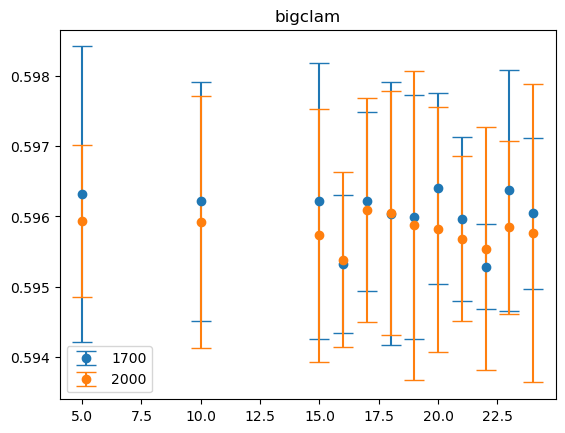

In [36]:
path_bigclam_BlogCatalog_1700 = 'unsupervised/find_communities/results/BlogCatalog/bigclam/1700/k_vs_auc_0.npy'
path_bigclam_BlogCatalog_2000 = 'unsupervised/find_communities/results/BlogCatalog/bigclam/2000/k_vs_auc_0.npy'

bigclam_BlogCatalog_1700 = np.load(path_bigclam_BlogCatalog_1700)
bigclam_BlogCatalog_2000 = np.load(path_bigclam_BlogCatalog_2000)

#todo: statistical analysis. think that the best will be to take mean - 2*sigma.
#plot error bars

ax = get_k_mean_std(bigclam_BlogCatalog_1700, verbose=True, label='1700')
get_k_mean_std(bigclam_BlogCatalog_2000, verbose=True, ax=ax, label='2000')

plt.legend()
plt.title('bigclam')


### ACM

Text(0.5, 1.0, 'bigclam')

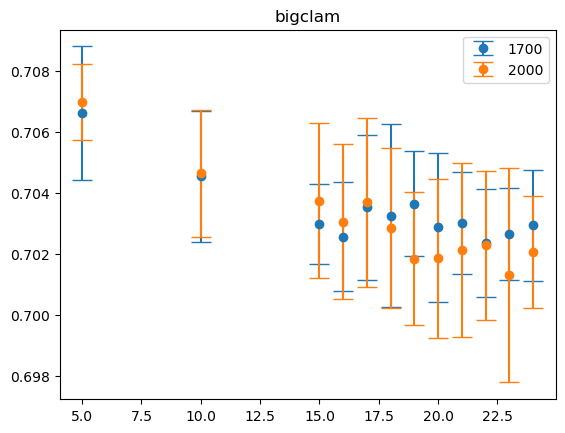

In [37]:
path_bigclam_ACM_1700 = 'unsupervised/find_communities/results/ACM/bigclam/1700/k_vs_auc_0.npy'
path_bigclam_ACM_2000 = 'unsupervised/find_communities/results/ACM/bigclam/2000/k_vs_auc_0.npy'

bigclam_ACM_1700 = np.load(path_bigclam_ACM_1700)
bigclam_ACM_2000 = np.load(path_bigclam_ACM_2000)

#todo: statistical analysis. think that the best will be to take mean - 2*sigma.
#plot error bars

ax = get_k_mean_std(bigclam_ACM_1700, verbose=True, label='1700')
get_k_mean_std(bigclam_ACM_2000, verbose=True, ax=ax, label='2000')

plt.legend()
plt.title('bigclam')


# Old Setting


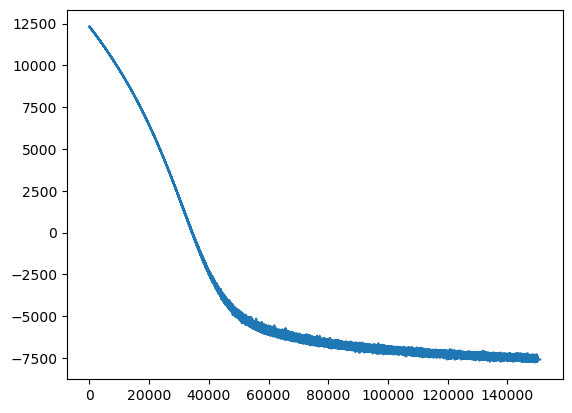

In [17]:

file_path = 'bigclam_then_prior3/results/losses/losses_16_16_2.txt'
array = np.loadtxt(file_path)

plt.plot(array)

In [ ]:
#todo: more experiments with 32 32 2 0.01. also try 64 32 2 0.01 and all the rest

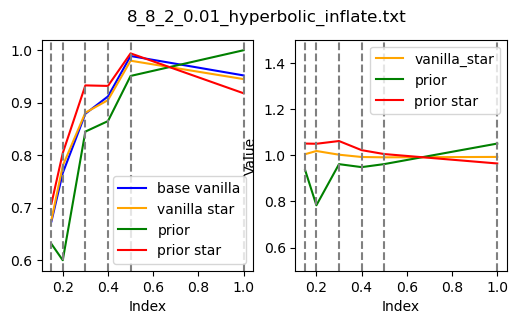

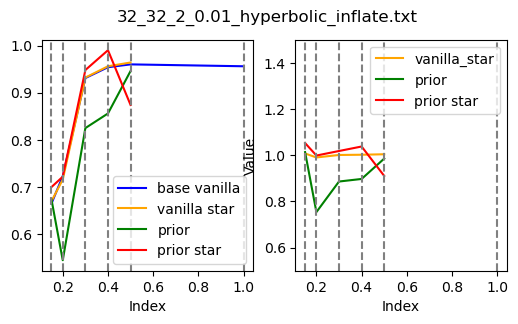

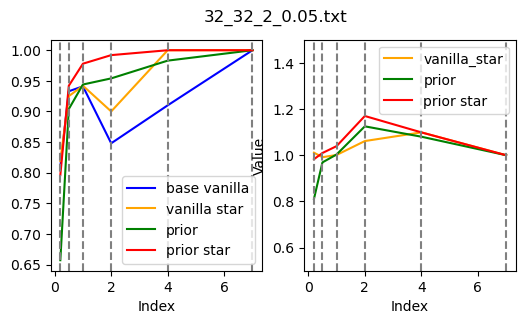

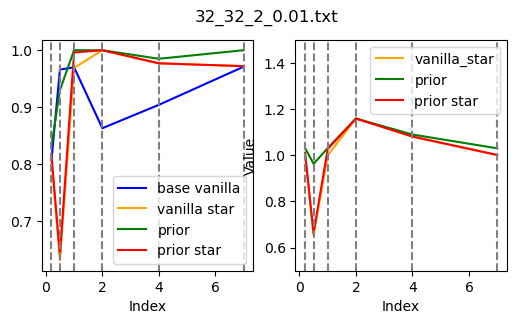

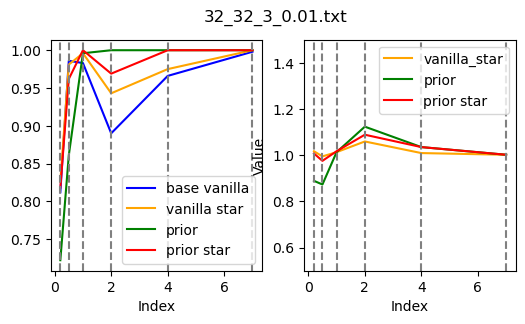

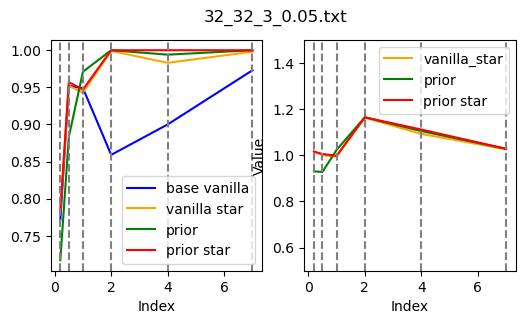

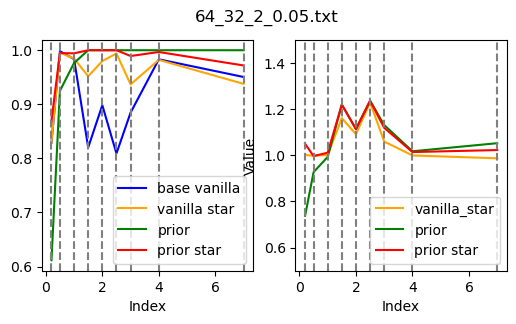

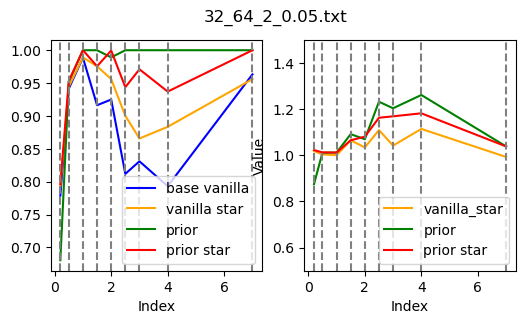

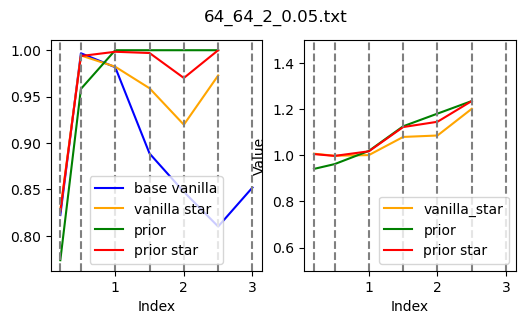

In [68]:
import numpy as np
import matplotlib.pyplot as plt

def plot_data(file_path, figsize=(12, 6)):
    array = np.loadtxt(file_path, comments='#')

    # Extract the file name from the file path
    file_name = os.path.basename(file_path)

    # Create a figure with two subplots
    fig, _ = plt.subplots(1, 2, figsize=figsize)

    # Define the colors for the plots
    colors = ['blue', 'orange', 'green', 'red']

    # Plot the columns of the array in the first subplot
    for i in range(1, array.shape[1]):
        plt.subplot(1, 2, 1)
        plt.plot(array[:, 0], array[:, i], color=colors[i-1])

    # Add legend and labels to the first subplot
    plt.subplot(1, 2, 1)
    plt.legend(['base vanilla', 'vanilla star', 'prior', 'prior star'])
    plt.xlabel('Index')

    plt.subplot(1, 2, 2)
    plt.ylabel('Value')
    plt.ylim(0.6, 1.02)

    new_array = array[:, 2:] / array[:, 1].reshape(-1, 1)

    # Plot the columns of the array in the second subplot
    for i in range(new_array.shape[1]):
        plt.subplot(1, 2, 2)
        plt.plot(array[:, 0], new_array[:, i], color=colors[i+1])

    # Add legend and labels to the second subplot
    plt.subplot(1, 2, 2)
    plt.legend(['vanilla_star', 'prior', 'prior star'])
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.ylim(0.5, 1.5)

    # Add vertical lines to each element of array[:, 0]
    for x in array[:, 0]:
        plt.subplot(1, 2, 1)
        plt.axvline(x, color='gray', linestyle='--')
        plt.subplot(1, 2, 2)
        plt.axvline(x, color='gray', linestyle='--')

    # Set the title of the plot as the file name
    plt.suptitle(file_name)

    plt.show()

# Plot the file path using the function
plot_data('results/avg_deg_tables/8_8_2_0.01_hyperbolic_inflate.txt', figsize=(6, 3))
plot_data('results/avg_deg_tables/32_32_2_0.01_hyperbolic_inflate.txt', figsize=(6, 3))
plot_data('results/avg_deg_tables/32_32_2_0.05.txt', figsize=(6, 3))

# Plot the file path that is plotted using the function
plot_data('results/avg_deg_tables/32_32_2_0.01.txt', figsize=(6, 3))

plot_data('results/avg_deg_tables/32_32_3_0.01.txt', figsize=(6, 3))
plot_data('results/avg_deg_tables/32_32_3_0.05.txt', figsize=(6, 3))
plot_data('results/avg_deg_tables/64_32_2_0.05.txt', figsize=(6, 3))
plot_data('results/avg_deg_tables/32_64_2_0.05.txt', figsize=(6, 3))
plot_data('results/avg_deg_tables/64_64_2_0.05.txt', figsize=(6, 3))





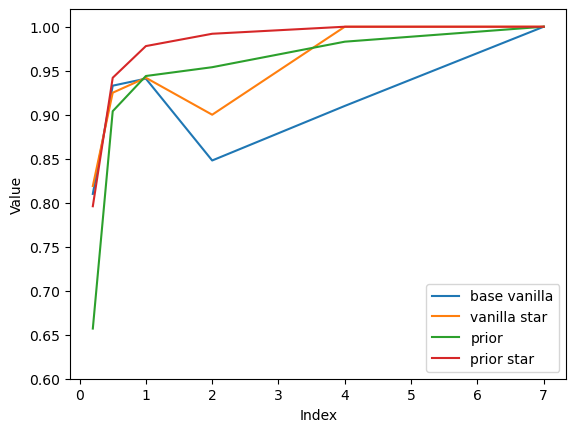

In [46]:
#todo: maybe it will make sense to show relative improvement

folder_path = 'results/avg_deg_tables/32_32_2_0.05.txt'
array = np.loadtxt(folder_path, comments='#')
import matplotlib.pyplot as plt

# Plot the columns of the array
for i in range(1,array.shape[1]):
    plt.plot(array[:,0],array[:, i])

# Add legend and labels
plt.legend(['base vanilla', 'vanilla star', 'prior', 'prior star'])
plt.xlabel('Index')
plt.ylabel('Value')

plt.ylim(0.6, 1.02)
# Show the plot
plt.show()

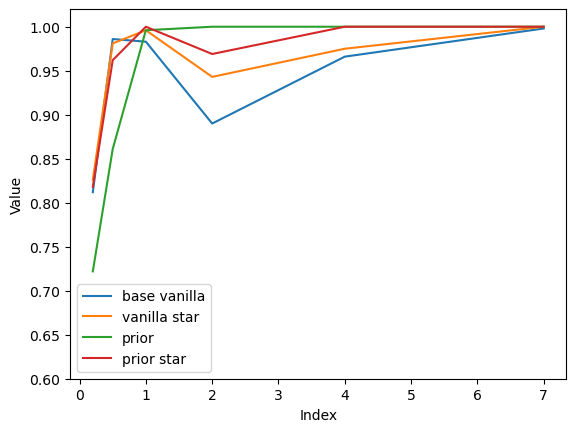

In [29]:
#todo: maybe it will make sense to show relative improvement

folder_path = 'results/avg_deg_tables/32_32_3_0.01.txt'
array = np.loadtxt(folder_path, comments='#')
import matplotlib.pyplot as plt

# Plot the columns of the array
for i in range(1,array.shape[1]):
    plt.plot(array[:,0],array[:, i])

# Add legend and labels
plt.legend(['base vanilla', 'vanilla star', 'prior', 'prior star'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.ylim(0.6, 1.02)
# Show the plot
plt.show()

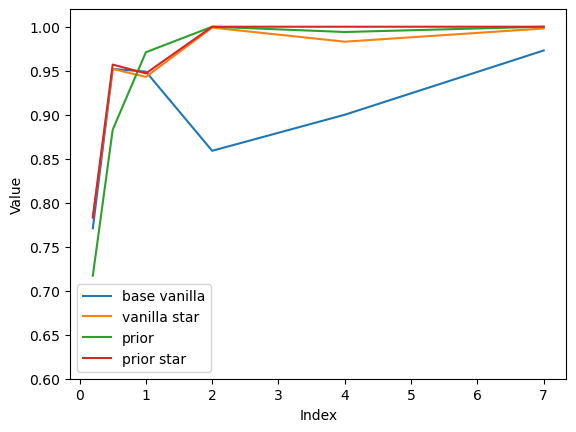

In [30]:
#todo: maybe it will make sense to show relative improvement

folder_path = 'results/avg_deg_tables/32_32_3_0.05.txt'
array = np.loadtxt(folder_path, comments='#')
import matplotlib.pyplot as plt

# Plot the columns of the array
for i in range(1,array.shape[1]):
    plt.plot(array[:,0],array[:, i])

# Add legend and labels
plt.legend(['base vanilla', 'vanilla star', 'prior', 'prior star'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.ylim(0.6, 1.02)
# Show the plot
plt.show()

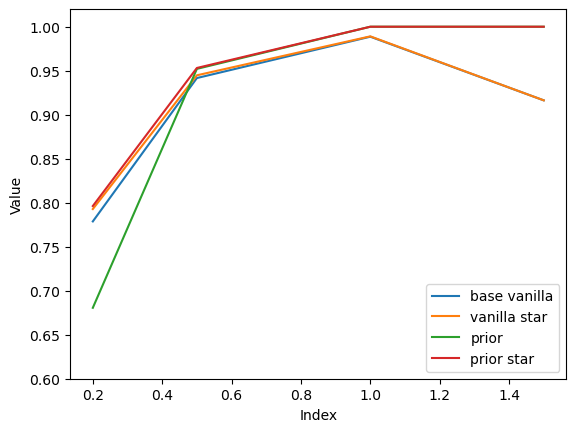

In [31]:
#todo: maybe it will make sense to show relative improvement

folder_path = 'results/avg_deg_tables/32_64_2_0.05.txt'
array = np.loadtxt(folder_path, comments='#')
import matplotlib.pyplot as plt

# Plot the columns of the array
for i in range(1,array.shape[1]):
    plt.plot(array[:,0],array[:, i])

# Add legend and labels
plt.legend(['base vanilla', 'vanilla star', 'prior', 'prior star'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.ylim(0.6, 1.02)
# Show the plot
plt.show()

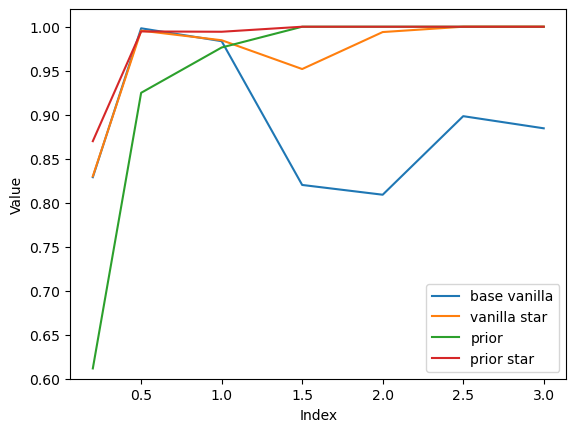

In [32]:
#todo: maybe it will make sense to show relative improvement

folder_path = 'results/avg_deg_tables/64_32_2_0.05.txt'
array = np.loadtxt(folder_path, comments='#')
import matplotlib.pyplot as plt

# Plot the columns of the array
for i in range(1,array.shape[1]):
    plt.plot(array[:,0],array[:, i])

# Add legend and labels
plt.legend(['base vanilla', 'vanilla star', 'prior', 'prior star'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.ylim(0.6, 1.02)
# Show the plot
plt.show()

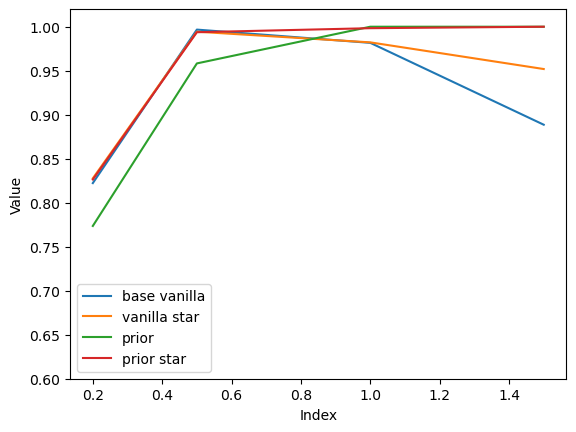

In [33]:
#todo: maybe it will make sense to show relative improvement

folder_path = 'results/avg_deg_tables/64_64_2_0.05.txt'
array = np.loadtxt(folder_path, comments='#')
import matplotlib.pyplot as plt

# Plot the columns of the array
for i in range(1,array.shape[1]):
    plt.plot(array[:,0],array[:, i])

# Add legend and labels
plt.legend(['base vanilla', 'vanilla star', 'prior', 'prior star'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.ylim(0.6, 1.02)
# Show the plot
plt.show()